**Автор: Анна Смелова**

## Курсовая работа по теме "Classification. Choose tutors" (Часть 2: Adaboost)
#### Geekbrains Algorithms for analyze data. Choose proper tutors for math exam
https://www.kaggle.com/c/classification-choose-tutors

**Материалы к проекту (файлы):**
train.csv, 
test.csv

**Задание:**
Предсказать **вероятность** того, подойдет ли репетитор для подготовки к экзамену по математике.

**Целевая переменная:**
choose

**Основная метрика:**
The evaluation metric is ROC AUC

**Пороговое значение метрики:**
logistic_regression 0.66965

**Ограничения:**
You can only use these imports:<br>
<font color='green'>
import numpy as np<br>
import pandas as pd<br>
from sklearn.model_selection import train_test_split<br>
from imblearn import over_sampling, under_sampling<br>
import matplotlib.pyplot as plt<br>
import seaborn as sns<br></font>

**В этой части курсовой работы будем использовать модель Real Adaboost для предсказания.** <br>
Это аналог классического дискретного Adaboost, только возвращающий вероятности вместо меток классов.<br>
Моя попытка реализовать следующий алгоритм:

Обобщением дискретного AdaBoost стал вещественный AdaBoost, использующий предикторы возвращающие значение вероятности принадлежности к классу. Множество значений слабого классификатора находится уже в области вещественных чисел. Знак $sign(f_m(x))$ определяет класс, а $|f_m(x)|$ вероятность. Ниже представлен алгоритм вещественного AdaBoost:<br>
1. Задаются начальные веса $w_i=\frac{1}{N},i=1,...,N$
2. Для каждого $m=1,2,...,N$ обучается классификатор, возвращающий вероятность $p(x)$ принадлежности к классу, используя обучающее множества с весами $w_i$, затем вычисляется ошибка классификатора $f_m(x)\leftarrow \frac{1}{2} \ln{\frac{p(x)}{1-p(x)}}$.
3. Далее необходимо обновить веса объектов $w_i=w_i*e^{-y_i*f_m(x_i)}$ и нормализовать их $w=\frac{w}{sum(w)}$.
4. Результат $sign\sum_{m=1}^M{f_m(x)}$.

<font color='DarkBlue'>Реализацию честно частично подглядела в самом scikit-learn.</font>

## Шаг 1: Подготовка инструментов

### 1.1 Необходимые модули

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.core.umath_tests import inner1d # для расчета ошибки классификатора
from numpy import trapz # для расчета площади под кривой
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1.2 Загрузка данных

Загрузим тренировочные данные в переменную **train_data**, тестовые данные в переменную **test_data**

In [2]:
train_data_base=pd.read_csv('classification-choose-tutors/train.csv')
train_data=train_data_base.copy()
train_data.shape

(10000, 13)

In [3]:
test_data_base=pd.read_csv('classification-choose-tutors/test.csv')
test_data=test_data_base.copy()
test_data.shape

(10000, 12)

### 1.3 Необходимые классы и функции

Функция для расчета основной метрики

In [4]:
def calc_roc_auc(y_pred, y):
    TP, FP, FN, TN = 0, 0, 0, 0
    l = len(y_pred)
    for i in range(l):
        if y_pred[i] == 1 and y[i] == 1:
            TP += 1
        elif y_pred[i] == 1 and y[i] == 0:
            FP += 1
        elif y_pred[i] == 0 and y[i] == 0:
            TN += 1
        elif y_pred[i] == 0 and y[i] == 1:
            FN += 1
            
    FPR = FP / (FP + TN)
    
    TPR = TP / (TP + FN)
    
    AUC_ROC = np.trapz([0,TPR,1], x = [0,FPR,1], dx=0.1)
    
    return AUC_ROC

Функция для подсчета точности как доли правильных ответов

In [5]:
def get_accuracy_metric(actual, predicted):
    correct = 0
    # получаем вероятности - преобразовываем в метка классов с порогом 0.5
    for i in range(len(predicted)): 
        if (predicted[i] > 0.5): 
            predicted[i] = 1
        elif (predicted[i] <= 0.5):
            predicted[i] = 0

    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [7]:
def plot_boxplot(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.box(True)
    plt.grid()
    my_pal = {'Train': 'LightGreen', 'Test': 'LightYellow'}
    df = pd.DataFrame({'Train' : train_data, 'Test' : test_data})
    sns.boxplot(x='value', y='variable', data=pd.melt(df), palette=my_pal)
    plt.show()

In [8]:
def plot_hist(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.xlabel(title)
    plt.grid()
    plt.hist(train_data, bins=15, density=False, label='Train', alpha=0.5, color='green')
    plt.hist(test_data, bins=15, density=False, label='Test', alpha=0.5, color='yellow')
    plt.legend()
    plt.show()

Классы для Adaboost

In [9]:
# Класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [10]:
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    # возвращает вероятности принадлежности к классам
    def predict(self):
        prediction = np.array([0., 0.])
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        classes[0] = 0
        classes[1] = 0
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction[0] = classes[0] / (classes[0] + classes[1])
        prediction[1] = classes[1] / (classes[0] + classes[1])

        return prediction

In [11]:
# Класс пня
class DecisionStump:
    
    def __init__(self, bad_splits):
       
        self.bad_splits = bad_splits
        self.data = [] # данные
        self.labels = [] # целевые метки    
        self.n_features = [] # количество признаков
        self.sample_weights = [] # веса объектов
        self.nodes = []
        self.leaves = []
        self.stump = None
        
    def get_best_feature_value(self, data, labels, sample_weights): 
            
        best_error = float('inf') # минимизируем ошибку, поэтому инициализируем ее большим значением
        best_feature = None # лучший признак для разделения
        best_value = None # лучшее значение признака
        
        # проходим по всем признакам
        for feature in range(self.n_features):
            # находим наиболее выгодное значение для разбиения текущего признака
            value, error = self.find_best_stump(feature, self.bad_splits)
            if (error < best_error):
                best_error = error
                best_value = value
                best_feature = feature
        
        return best_feature, best_value, best_error
            
    # подбор наилучшего разбиения для пня
    def find_best_stump(self, feature, # исследуемый признак 
                        bad_splits): # массив признак-значение с неудачными разделениями
        
        feature_values = sorted(np.unique(self.data[:,feature]))
        
        best_value = None
        best_error = float('inf')
        
        for value in feature_values[:-1]:
            
            if feature in bad_splits.keys():
                if value in bad_splits[feature]:
                    continue
                    
            predict = self.predict_train(feature, value)
            
            error = self.calculate_error(predict)
            
            if error < best_error:
                best_error = error
                best_value = value
                 
        return best_value, best_error
    
    # разбиение пня на две ветки по переданному признаку и его значению
    def split(self, data, labels, sample_weights, feature, value):
        
        left = np.where(data[:, feature] <= value)
        right = np.where(data[:, feature] > value)
        
        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]
        
        true_weights = sample_weights[left]
        false_weights = sample_weights[right]
        
        return true_data, false_data, true_labels, false_labels, true_weights, false_weights, left, right
    
    # предсказание для переданной ветки пня (ветку передаем набором находящихся в ней меток)
    def predict_leaf(self, labels):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction
    
    # предсказание для разбиения по переданному признаку и его значению
    def predict_train(self, feature, value):
        
        true_data, false_data, true_labels, false_labels, true_weights, false_weights, left, right = self.split(self.data, self.labels, self.sample_weights, feature, value)
        
        predict = np.zeros(self.labels.shape)
        
        predict[left] = [self.predict_leaf(true_labels)] * len(true_labels)
        predict[right] = [self.predict_leaf(false_labels)] * len(false_labels)
        
        return predict
    
    # ошибку считаем как сумму весов неправильно классифицированных объектов
    def calculate_error(self, predict):
        
        error = 0
        
        for i in range(len(self.labels)):
            if predict[i] != self.labels[i]:
                error += self.sample_weights[i]
                
        return error
    
    # Построение дерева с помощью рекурсивной функции
    def build_stump(self, data, labels, sample_weights, is_leaf=False):
        
        if is_leaf:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        self.feature, self.value, self.best_error = self.get_best_feature_value(data, labels, sample_weights)
        
        true_data, false_data, true_labels, false_labels, true_weights, false_weights, left, right = self.split(data, labels, sample_weights, self.feature, self.value)

        # строим две ветки
        true_branch = self.build_stump(true_data, true_labels, true_weights, is_leaf=True)
        false_branch = self.build_stump(false_data, false_labels, false_weights, is_leaf=True)

        # Возвращаем класс узла, то есть пня
        self.nodes.append(Node(self.feature, self.value, true_branch, false_branch))
        return Node(self.feature, self.value, true_branch, false_branch)
    
    def fit(self, data, labels, sample_weights):
        
        self.data = np.array(data)
        self.labels = np.array(labels)
        self.n_features = self.data.shape[1]
        self.sample_weights = np.array(sample_weights)
        
        self.stump = self.build_stump(data, labels, sample_weights)
        return self
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.stump)
            classes.append(prediction)
        return np.array(classes)

In [13]:
# Класс AdaBoost
class AdaBoost:
    def __init__(self, n_trees, learning_rate=0.5): # количествоо деревьев 
        
        self.n_trees = n_trees
        self.bad_splits = {}
        self.forest = []  
        self.train_accuracy = []
        self.test_accuracy = []
        self.train_roc = []
        self.test_roc = []
        self.stump_weights = []
        self.learning_rate = learning_rate
        
    # Функция подсчета ошибки
    def get_stump_error(self, pred, y, sample_weight):
        
        pred_class = pred[:,1].copy()
        
        for i in range(len(pred_class)):
            if (pred_class[i] > 0.5): 
                pred_class[i] = 1
            elif (pred_class[i] <= 0.5):
                pred_class[i] = 0
        
        pred_class = np.array(pred_class)
        incorrect = pred_class != y
        #err = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        err = sum(pred_class != y) / len(y)
        return err
   
    # Сам алгоритм
    def adaboost(self, X, y, X_valid, y_valid, get_err):
        # Размер выборки
        n_objects = len(X)

        # Запишем количество классов в переменную
        n_classes = len(np.unique((y)))
        classes = np.array([0, 1])
        
        y_codes = np.array([-1./(n_classes - 1), 1.])
        y_coding = y_codes.take(classes == y[:,np.newaxis])#[:,1]

        # Начальные веса объектов
        w = np.ones(n_objects) / n_objects

        # Деревья с весами будем записывать в список
        self.forest = []
        
        bad_trees_n = 0

        for n in range(self.n_trees):
            
            clf = DecisionStump(self.bad_splits)
            clf.fit(X, y, w)

            y_predict_proba = clf.predict(X)
            y_predict_proba[y_predict_proba<=0] = 1e-5 # обрабатываем граничные значения
            
            stump_error = self.get_stump_error(y_predict_proba, y, w)

            # отбросим дерево, если его ошибка больше 0.5
            if stump_error >= 1 - 1/n_classes:
                
                if clf.feature in self.bad_splits.keys():
                    self.bad_splits[clf.feature].append(clf.value)
                else:
                    self.bad_splits[clf.feature] = [clf.value]
                bad_trees_n += 1
                continue
            
            # вес пня нужен только для перерасчета весов объектов
            stump_weight = (-1. * 0.5 * inner1d(y_coding, np.log(y_predict_proba)))
            # пересчитаем веса объектов
            w *= np.exp(stump_weight *((w > 0) | (stump_weight < 0)))
            # нормализуем веса
            w /= w.sum()

            # Добавим дерево с весом 1 в список
            self.stump_weights.append(1)
            self.forest.append((1, clf))
            
            # записываем ошибки на каждой итерации для визуализации обучения
            if get_err:
            
                train_labels_pred = self.predict(X)
                test_labels_pred = self.predict(X_valid)
                train_accuracy = get_accuracy_metric(y, train_labels_pred)
                test_accuracy = get_accuracy_metric(y_valid, test_labels_pred)
                train_roc = calc_roc_auc(train_labels_pred, y)
                test_roc = calc_roc_auc(test_labels_pred, y_valid)

                self.train_accuracy.append(train_accuracy)
                self.test_accuracy.append(test_accuracy)
                self.train_roc.append(train_roc)
                self.test_roc.append(test_roc)

        return self
    
    def fit(self, data, labels, test_data, test_labels, get_err=False): 
        return self.adaboost(data, labels, test_data, test_labels, get_err)
    
    def predict(self, X):
        proba = np.array(sum(clf.predict(X) for f, clf in self.forest))
        n_classes = 2
        
        proba /= np.sum(self.stump_weights)
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer
        
        # возвращаем вероятности только для класса 1
        return proba[:,1]

In [14]:
def plot_errors(a_trees, train_roc, test_roc, train_acc, test_acc):
    plt.figure(figsize=(16,7))
    
    plt.subplot(1,2,1)
    plt.plot(a_trees, train_roc, c='green', label='Train')
    plt.plot(a_trees, test_roc, c='red', label='Test')
    plt.xlabel('Количество деревьев')
    plt.ylabel('ROC_AUC')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(a_trees, train_acc, c='LightGreen', label='Train')
    plt.plot(a_trees, test_acc, c='coral', label='Test')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Проверка модели на синтетических данных**

In [15]:
from sklearn.datasets import make_classification
classification_data, classification_labels = make_classification(n_samples=200, n_features=7, n_informative=5, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=9)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(classification_data, classification_labels, test_size=0.3, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(140, 7) (60, 7) (140,) (60,)


Train Accuracy 97.85714285714285
Test Accuracy 95.0

Train ROC_AUC 0.9794520547945205
Test ROC_AUC 0.9513574660633485



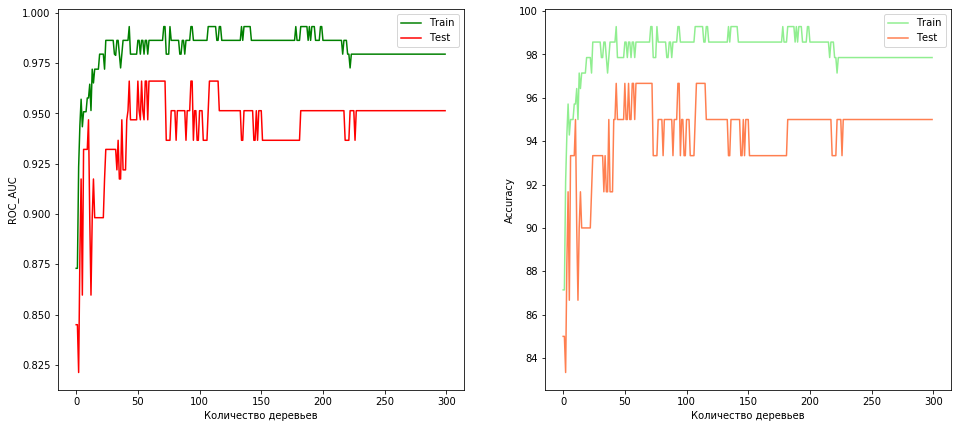

CPU times: user 1min 5s, sys: 164 ms, total: 1min 5s
Wall time: 1min 6s


In [17]:
%%time
n_trees = 300
adaboost = AdaBoost(n_trees=n_trees).fit(X_train, y_train, X_valid, y_valid, get_err=True)
train_labels_a = adaboost.predict(X_train)
test_labels_a = adaboost.predict(X_valid)

# Точность на обучающей выборке
train_accuracy_a = get_accuracy_metric(y_train, train_labels_a)
train_error_a = get_error(y_train, train_labels_a)
# Точность на тестовой выборке
test_accuracy_a = get_accuracy_metric(y_valid, test_labels_a)
test_error_a = get_error(y_valid, test_labels_a)

print(f'Train Accuracy {train_accuracy_a}')
print(f'Test Accuracy {test_accuracy_a}')
print()
print(f'Train ROC_AUC {calc_roc_auc(train_labels_a, y_train)}')
print(f'Test ROC_AUC {calc_roc_auc(test_labels_a, y_valid)}')
print()

plot_errors(list(range(n_trees)), adaboost.train_roc, adaboost.test_roc, adaboost.train_accuracy, adaboost.test_accuracy)

Видно, что алгоритм немного переобучается, но в целом со своей задачей справляется.

## Шаг 2: Подготовка данных

In [18]:
train_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [19]:
test_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


### 2.1 Обработка пропущенных значений и выбросов в данных

In [20]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8009,8.030274,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9748,1.766883,0.0,0.00,2.0,3.00,9.0
lesson_price,10000.0,1702.4400,523.789062,200.0,1300.00,1550.0,2150.00,3950.0
qualification,10000.0,1.7243,0.798845,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3706,0.482990,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1215,0.326724,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1172,0.321675,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0591,0.235824,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0277,0.164120,0.0,0.00,0.0,0.00,1.0


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [22]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,14999.5000,2886.895680,10000.0,12499.75,14999.5,17499.25,19999.0
age,10000.0,45.9245,8.031977,23.0,41.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9857,1.771217,0.0,0.00,2.0,3.00,9.0
lesson_price,10000.0,1699.9100,526.260094,300.0,1300.00,1550.0,2150.00,3950.0
qualification,10000.0,1.7023,0.789644,1.0,1.00,1.5,2.00,4.0
physics,10000.0,0.3721,0.483389,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1281,0.334218,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1158,0.320001,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0490,0.215879,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0292,0.168375,0.0,0.00,0.0,0.00,1.0


In [23]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


Пропусков в данных нет.<br>
Выбросов в данных также не видно. Но, на всякий случай посмотрим более детально на признак "lesson_price".

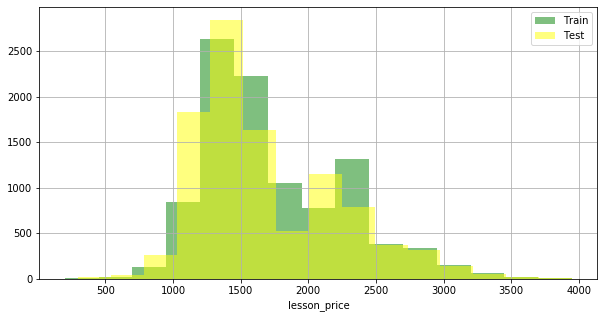

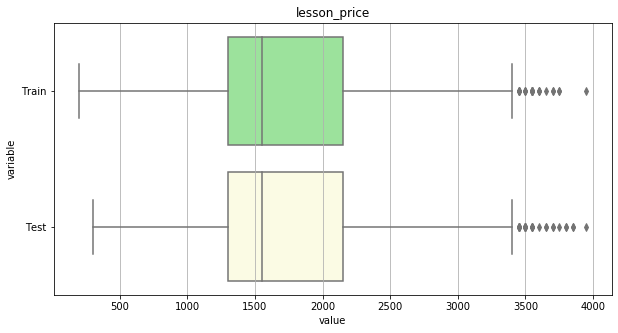

In [24]:
plot_hist('lesson_price', train_data['lesson_price'], test_data['lesson_price'])
plot_boxplot('lesson_price', train_data['lesson_price'], test_data['lesson_price'])

Значения, которые превышают 3400 можно считать выбросами. Но, так как они есть и в тренировочной выборке и в тестовой, не будем удалять их.

### 2.2 Поиск взаимосвязей между признаками

Разделим признаки на количественные, ранговые и категориальные (признак "Id" пока добавим в ранговые, а потом уберем, т.к. он неинформативный, признак "age" добавим в количественные):

In [25]:
cat_features = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'choose']
rank_features = ['Id', 'years_of_experience', 'qualification']
num_features = ['age', 'lesson_price', 'mean_exam_points']

In [26]:
train_data_num = train_data[num_features]
train_data_rank = train_data[rank_features]
train_data_cat = train_data[cat_features]

test_data_num = test_data[num_features]
test_data_rank = test_data[rank_features]
test_data_cat = test_data[cat_features[:-1]]

Для количественных признаков посмотрим на матрицу корреляции.

In [27]:
corr_features = num_features + ['choose']
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points,choose
age,1,0.00069,0.0041,0.017
lesson_price,0.00069,1,0.73,-0.13
mean_exam_points,0.0041,0.73,1,0.11
choose,0.017,-0.13,0.11,1


Признаки "lesson_price" и "mean_exam_points" высоко коррелируют между собой, но недостаточно, чтобы удалить один из них.

Для категориальных и ранговых признаков псмотрим на взаимную информацию между признаками и целевой переменной.<br>
Сначала разделим признаки тренировочной выборки на непосредственно признаки и на целевую переменную. Признак "Id" неинформативный - тоже выделим его в отдельную переменную.

In [28]:
target = train_data_cat['choose']
train_ids = train_data_rank['Id'].astype('int64')
train_num = train_data_num
train_rank = train_data_rank.drop(['Id'],axis=1)
train_cat = train_data_cat.drop(['choose'],axis=1)

Для подсчета взаимной информации надо, чтобы признак был дискретным.

In [29]:
from sklearn.metrics.cluster import contingency_matrix
def get_mi(x, y):
    mi = 0
    cm = contingency_matrix(y, x)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            size = np.sum(cm)
            p_x_y = cm[i][j] / size
            p_x = np.sum(cm[:, j]) / size
            p_y = np.sum(cm[i]) / size

            if p_x_y == 0:
                continue
            mi += p_x_y * np.log(p_x_y / (p_x * p_y))
    return mi

In [30]:
for cat in train_cat.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_cat[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.018310514044706433
Взаимная информация признака chemistry с целевой переменной 0.0036711220021946444
Взаимная информация признака biology с целевой переменной 0.0022637017162383385
Взаимная информация признака english с целевой переменной 0.0002319468679485839
Взаимная информация признака geography с целевой переменной 1.9682676972689636e-05
Взаимная информация признака history с целевой переменной 1.1370782112761783e-05


In [31]:
for cat in train_rank.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_rank[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.0011498680108282845
Взаимная информация признака qualification с целевой переменной 0.0013668439216665876


Одномерный отбор не показал особой "силы" категориальных и ранговых признаков.

### 2.3 Добавление новых признаков

#### 2.3.1 Суммарное количество предметов помимо математики у преподавателя

In [32]:
train_subjects = train_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
train_data['subjects_num'] = train_subjects

test_subjects = test_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
test_data['subjects_num'] = test_subjects

rank_features.append('subjects_num') # это ранговый признак

print(train_data['subjects_num'].value_counts())

0.0    4381
1.0    4252
2.0    1216
3.0     147
4.0       4
Name: subjects_num, dtype: int64


#### 2.3.2 Скорость достижения квалификации

In [33]:
train_qual_speed = train_data['qualification'] / train_data['age']
train_data['qual_speed'] = train_qual_speed

test_qual_speed = test_data['qualification'] / test_data['age']
test_data['qual_speed'] = test_qual_speed

num_features.append('qual_speed') # это количественный признак

#### 2.3.3 Преподаватель в возрасте или молодой

In [34]:
train_old = (train_data['age']>train_data['age'].quantile(.75)).astype('int64')
train_data['old'] = train_old
train_young = (train_data['age']<train_data['age'].quantile(.25)).astype('int64')
train_data['young'] = train_young
train_data['med'] = [1] * train_data.shape[0]
train_data['med'] = train_data['med'] - train_data['young'] - train_data['old']

test_old = (test_data['age']>test_data['age'].quantile(.75)).astype('int64')
test_data['old'] = test_old
test_young = (test_data['age']<test_data['age'].quantile(.25)).astype('int64')
test_data['young'] = test_young
test_data['med'] = [1] * test_data.shape[0]
test_data['med'] = test_data['med'] - test_data['young'] - test_data['old']

cat_features.append('old') # это категориальный признак
cat_features.append('young') # это категориальный признак
cat_features.append('med') # это категориальный признак

#### 2.3.4 Дорогой или дешевый урок

In [35]:
train_expensive = (train_data['lesson_price']>train_data['lesson_price'].quantile(.75)).astype('int64')
train_data['expensive'] = train_expensive
train_cheap = (train_data['lesson_price']<train_data['lesson_price'].quantile(.25)).astype('int64')
train_data['cheap'] = train_cheap
train_data['ok'] = [1] * train_data.shape[0]
train_data['ok'] = train_data['ok'] - train_data['expensive'] - train_data['cheap']

test_expensive = (test_data['lesson_price']>test_data['lesson_price'].quantile(.75)).astype('int64')
test_data['expensive'] = test_expensive
test_cheap = (test_data['lesson_price']<test_data['lesson_price'].quantile(.25)).astype('int64')
test_data['cheap'] = test_cheap
test_data['ok'] = [1] * test_data.shape[0]
test_data['ok'] = test_data['ok'] - test_data['expensive'] - test_data['cheap']

cat_features.append('expensive') # это категориальный признак
cat_features.append('cheap') # это категориальный признак
cat_features.append('ok') # это категориальный признак

#### 2.3.5 Преподаватель с высокой квалификацией

In [36]:
train_high_qualification = (train_data['qualification']>=3).astype('int64')
train_data['high_qualification'] = train_high_qualification

test_high_qualification = (test_data['qualification']>=3).astype('int64')
test_data['high_qualification'] = test_high_qualification

cat_features.append('high_qualification') # это категориальный признак

Снова посмотрим на взаимосвязи между признаками.

In [37]:
corr_features = num_features + ['choose']
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points,qual_speed,choose
age,1,0.00069,0.0041,-0.37,0.017
lesson_price,0.00069,1,0.73,0.72,-0.13
mean_exam_points,0.0041,0.73,1,0.69,0.11
qual_speed,-0.37,0.72,0.69,1,0.029
choose,0.017,-0.13,0.11,0.029,1


In [38]:
for cat in cat_features:
    if cat != 'choose':
        print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.018310514044706433
Взаимная информация признака chemistry с целевой переменной 0.0036711220021946444
Взаимная информация признака biology с целевой переменной 0.0022637017162383385
Взаимная информация признака english с целевой переменной 0.0002319468679485839
Взаимная информация признака geography с целевой переменной 1.9682676972689636e-05
Взаимная информация признака history с целевой переменной 1.1370782112761783e-05
Взаимная информация признака old с целевой переменной 0.00031929509077941376
Взаимная информация признака young с целевой переменной 4.473826036929156e-05
Взаимная информация признака med с целевой переменной 9.94016088578342e-05
Взаимная информация признака expensive с целевой переменной 0.0017034327194639263
Взаимная информация признака cheap с целевой переменной 0.0070347725597272
Взаимная информация признака ok с целевой переменной 0.0015281666634979069
Взаимная информация признака high_qualification с цел

In [39]:
for cat in rank_features:
    if cat!='Id':
        print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.0011498680108282845
Взаимная информация признака qualification с целевой переменной 0.0013668439216665876
Взаимная информация признака subjects_num с целевой переменной 0.021435503006294005


Получилось, что у признака "subjects_num" и признака "physics" самая высокая взаимная информация. Удалим признаки "english", "geography", "history", 'old', 'young', 'med' и 'high_qualification' как неинформативные.

In [40]:
cat_features = ['physics', 'chemistry', 'biology', 'cheap','expensive', 'ok']
rank_features = ['years_of_experience', 'qualification', 'subjects_num']
num_features = ['age', 'lesson_price', 'mean_exam_points', 'qual_speed']
target_feature = 'choose'
id_feature = ['Id']

In [41]:
train_num = train_data[num_features]
train_rank = train_data[rank_features]
train_cat = train_data[cat_features]
target = train_data[target_feature]
train_ids = train_data[id_feature]

test_num = test_data[num_features]
test_rank = test_data[rank_features]
test_cat = test_data[cat_features]
test_ids = test_data[id_feature]

### 2.4 Масштабирование признаков

Все категориальные признаки представляют из себя наборы из 0 и 1.

In [42]:
train_cat.describe()

,physics,chemistry,biology,cheap,expensive,ok
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.37060,0.121500,0.117200,0.21120,0.228400,0.560400
std,0.48299,0.326724,0.321675,0.40818,0.419823,0.496363
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,1.00000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000


Всем ранговым признакам поставим в соответствие наборы из 0 и 1, используя для этого dummy-переменные:

In [43]:
for feature in train_rank.columns:
    train_rank[feature] = train_rank[feature].astype(object)
train_rank = pd.get_dummies(train_rank)
    
for feature in test_rank.columns:
    test_rank[feature] = test_rank[feature].astype(object)
test_rank = pd.get_dummies(test_rank)

print(train_rank.shape, test_rank.shape)

(10000, 19) (10000, 19)


/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
# Проверим, что полученные признаки совпадают
print(train_rank.columns == test_rank.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


In [45]:
train_rank.describe()

,years_of_experience_0.0,years_of_experience_1.0,years_of_experience_2.0,years_of_experience_3.0,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,subjects_num_0.0,subjects_num_1.0,subjects_num_2.0,subjects_num_3.0,subjects_num_4.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.277400,0.184200,0.174300,0.154500,0.117700,0.058100,0.023400,0.007300,0.002200,0.000900,0.489100,0.303300,0.201800,0.00580,0.438100,0.425200,0.12160,0.014700,0.000400
std,0.447738,0.387667,0.379386,0.361445,0.322269,0.233944,0.151178,0.085132,0.046855,0.029988,0.499906,0.459707,0.401364,0.07594,0.496178,0.494398,0.32684,0.120355,0.019997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000


Отмасштабируем получившиеся количественные признаки методом нормализации.

In [46]:
# TRAIN
train_num_min = np.min(train_num, axis=0)
train_num_max = np.max(train_num, axis=0)

# TEST
test_num_min = np.min(test_num, axis=0)
test_num_max = np.max(test_num, axis=0)

#display(train_num_min, test_num_min, train_num_max, test_num_max)

In [47]:
train_num_d = train_num_max - train_num_min
test_num_d = test_num_max - test_num_min

train_num_norm = train_num.to_numpy(copy='True')
test_num_norm = test_num.to_numpy(copy='True')

# вычтем из каждого значения признака минимум и поделим на разность между максимумом и минимумом
for i in range(train_num_norm.shape[0]):
    for j in range(train_num_norm.shape[1]):
        train_num_norm[i][j] = (train_num_norm[i][j] - train_num_min[j]) / train_num_d[j]
        
for k in range(test_num_norm.shape[0]):
    for m in range(test_num_norm.shape[1]):
        test_num_norm[k][m] = (test_num_norm[k][m] - test_num_min[m]) / test_num_d[m]

In [48]:
# TRAIN
train_num_min = np.min(train_num_norm, axis=0)
train_num_max = np.max(train_num_norm, axis=0)

# TEST
test_num_min = np.min(test_num_norm, axis=0)
test_num_max = np.max(test_num_norm, axis=0)

display(train_num_min, test_num_min, train_num_max, test_num_max)

array([0., 0., 0., 0.])

array([0., 0., 0., 0.])

array([1., 1., 1., 1.])

array([1., 1., 1., 1.])

### 2.5 Объединение признаков

Объединим полученные признаки.

In [49]:
print(train_ids.columns)
print(train_num.columns)
print(train_cat.columns)
print(train_rank.columns)

Index(['Id'], dtype='object')
Index(['age', 'lesson_price', 'mean_exam_points', 'qual_speed'], dtype='object')
Index(['physics', 'chemistry', 'biology', 'cheap', 'expensive', 'ok'], dtype='object')
Index(['years_of_experience_0.0', 'years_of_experience_1.0',
       'years_of_experience_2.0', 'years_of_experience_3.0',
       'years_of_experience_4.0', 'years_of_experience_5.0',
       'years_of_experience_6.0', 'years_of_experience_7.0',
       'years_of_experience_8.0', 'years_of_experience_9.0',
       'qualification_1.0', 'qualification_2.0', 'qualification_3.0',
       'qualification_4.0', 'subjects_num_0.0', 'subjects_num_1.0',
       'subjects_num_2.0', 'subjects_num_3.0', 'subjects_num_4.0'],
      dtype='object')


In [50]:
features = list(train_num.columns) + list(train_cat.columns) + list(train_rank.columns)
features

['age',
 'lesson_price',
 'mean_exam_points',
 'qual_speed',
 'physics',
 'chemistry',
 'biology',
 'cheap',
 'expensive',
 'ok',
 'years_of_experience_0.0',
 'years_of_experience_1.0',
 'years_of_experience_2.0',
 'years_of_experience_3.0',
 'years_of_experience_4.0',
 'years_of_experience_5.0',
 'years_of_experience_6.0',
 'years_of_experience_7.0',
 'years_of_experience_8.0',
 'years_of_experience_9.0',
 'qualification_1.0',
 'qualification_2.0',
 'qualification_3.0',
 'qualification_4.0',
 'subjects_num_0.0',
 'subjects_num_1.0',
 'subjects_num_2.0',
 'subjects_num_3.0',
 'subjects_num_4.0']

In [51]:
train_norm = np.hstack((train_num_norm, train_cat, train_rank))

test_norm = np.hstack((test_num_norm, test_cat, test_rank))

### 2.6 Балансировка данных

Посмотрим, на то, как представлены целевые классы в выборке.

In [52]:
target.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [53]:
disbalance = target.value_counts()[0] / target.value_counts()[1]
disbalance

8.017132551848512

In [54]:
# Oversampling
oversample = over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over_norm, y_over_norm = oversample.fit_resample(train_norm, target)
print(f'До oversampling:\n{target.value_counts()}')
print(f'\nПосле oversampling:\n{y_over_norm.value_counts()}')

До oversampling:
0    8891
1    1109
Name: choose, dtype: int64

После oversampling:
1    8891
0    8891
Name: choose, dtype: int64


In [55]:
# Undersampling
undersample = under_sampling.RandomUnderSampler(sampling_strategy='majority')
X_under_norm, y_under_norm = undersample.fit_resample(train_norm, target)
print(f'До undersampling:\n{target.value_counts()}')
print(f'\nПосле undersampling:\n{y_under_norm.value_counts()}')

До undersampling:
0    8891
1    1109
Name: choose, dtype: int64

После undersampling:
1    1109
0    1109
Name: choose, dtype: int64


In [56]:
display(X_under_norm.shape, test_norm.shape)

(2218, 29)

(10000, 29)

### 2.7 Обучающая и валидационная выборки

Перемешивание датасета

In [57]:
# перемешивание датасета
np.random.seed(12)
shuffle_index_o = np.random.permutation(X_over_norm.shape[0])
X_on, y_on = X_over_norm[shuffle_index_o], y_over_norm[shuffle_index_o]

shuffle_index_u = np.random.permutation(X_under_norm.shape[0])
X_un, y_un = X_under_norm[shuffle_index_u], y_under_norm[shuffle_index_u]

Разобьем тренировочные данные на обучающую и валидационную выборки. <br>
Получится два набора данных с разным типом балансировки.

In [58]:
X_train_over_norm, X_valid_over_norm, y_train_over_norm, y_valid_over_norm = train_test_split(X_on, y_on, test_size=0.3, random_state=42)

In [59]:
print(X_train_over_norm.shape, X_valid_over_norm.shape, y_train_over_norm.shape, y_valid_over_norm.shape)

(12447, 29) (5335, 29) (12447,) (5335,)


In [60]:
y_train_over_norm = np.array(y_train_over_norm)
y_valid_over_norm = np.array(y_valid_over_norm)

In [61]:
X_train_under_norm, X_valid_under_norm, y_train_under_norm, y_valid_under_norm = train_test_split(X_un, y_un, test_size=0.3, random_state=42)

In [62]:
print(X_train_under_norm.shape, X_valid_under_norm.shape, y_train_under_norm.shape, y_valid_under_norm.shape)

(1552, 29) (666, 29) (1552,) (666,)


In [63]:
y_train_under_norm = np.array(y_train_under_norm)
y_valid_under_norm = np.array(y_valid_under_norm)

## Шаг 3: Подбор параметров модели

Будем подбирать параметры моделей и записывать адекватные результаты в датафрейм.

In [64]:
models_results = pd.DataFrame()
dataset = []
accuracy_train_result = []
accuracy_test_result = []
roc_auc_train_result = []
roc_auc_test_result = []
model_params = []

76.25933959990358 0.7626011471149785
76.1012183692596 0.7609978787315788


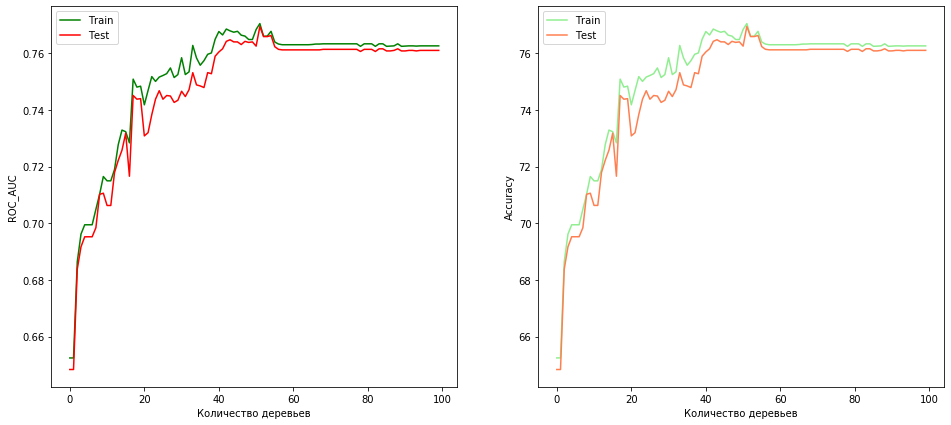

CPU times: user 11min 37s, sys: 7.42 s, total: 11min 45s
Wall time: 11min 43s


In [72]:
%%time
# Oversampling norm
d_name = 'Oversampling_norm'
n_trees=100
adaboost = AdaBoost(n_trees=n_trees) 
adaboost.fit(X_train_over_norm, y_train_over_norm, X_valid_over_norm, y_valid_over_norm, get_err=True)
        
train_labels_over_norm = adaboost.predict(X_train_over_norm)
test_labels_over_norm = adaboost.predict(X_valid_over_norm)
        
train_accuracy_over_norm = get_accuracy_metric(y_train_over_norm, train_labels_over_norm)
test_accuracy_over_norm = get_accuracy_metric(y_valid_over_norm, test_labels_over_norm)
        
train_roc_over_norm = calc_roc_auc(train_labels_over_norm, y_train_over_norm)
test_roc_over_norm = calc_roc_auc(test_labels_over_norm, y_valid_over_norm)
        
print(train_accuracy_over_norm, train_roc_over_norm)
print(test_accuracy_over_norm, test_roc_over_norm)
        
for n in list(range(n_trees)):
    if adaboost.test_roc[n] > 0.66965:
        dataset.append(d_name)
        accuracy_train_result.append(adaboost.train_accuracy[n])
        accuracy_test_result.append(adaboost.test_accuracy[n])
        roc_auc_train_result.append(adaboost.train_roc[n])
        roc_auc_test_result.append(adaboost.test_roc[n])
        model_params.append(n)
        
plot_errors(list(range(n_trees)), adaboost.train_roc, adaboost.test_roc, adaboost.train_accuracy, adaboost.test_accuracy)

78.54381443298969 0.7854286544609126
76.72672672672672 0.7672065507539138


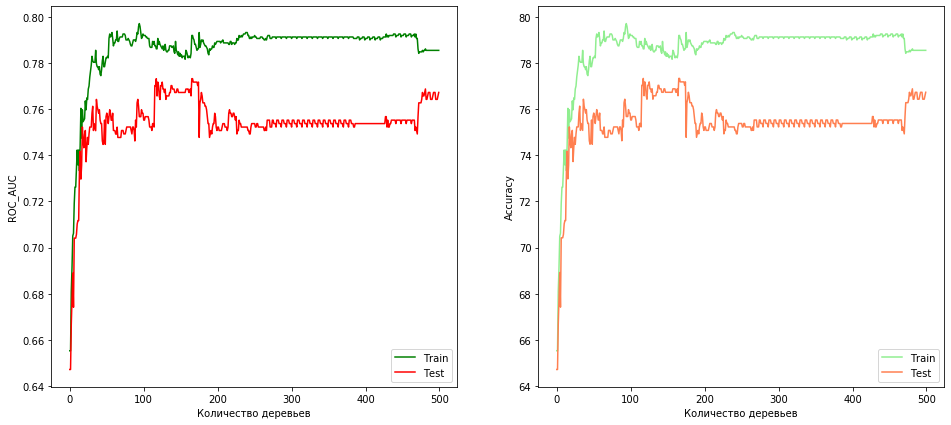

CPU times: user 12min 45s, sys: 5.39 s, total: 12min 50s
Wall time: 13min 29s


In [73]:
%%time
# Undersampling norm
d_name = 'Undersampling_norm'
n_trees=500
adaboost = AdaBoost(n_trees=n_trees) 
adaboost.fit(X_train_under_norm, y_train_under_norm, X_valid_under_norm, y_valid_under_norm, get_err=True)
        
train_labels_under_norm = adaboost.predict(X_train_under_norm)
test_labels_under_norm = adaboost.predict(X_valid_under_norm)
        
train_accuracy_under_norm = get_accuracy_metric(y_train_under_norm, train_labels_under_norm)
test_accuracy_under_norm = get_accuracy_metric(y_valid_under_norm, test_labels_under_norm)
        
train_roc_under_norm = calc_roc_auc(train_labels_under_norm, y_train_under_norm)
test_roc_under_norm = calc_roc_auc(test_labels_under_norm, y_valid_under_norm)
        
print(train_accuracy_under_norm, train_roc_under_norm)
print(test_accuracy_under_norm, test_roc_under_norm)
        
for n in list(range(n_trees)):
    if adaboost.test_roc[n] > 0.66965:
        dataset.append(d_name)
        accuracy_train_result.append(adaboost.train_accuracy[n])
        accuracy_test_result.append(adaboost.test_accuracy[n])
        roc_auc_train_result.append(adaboost.train_roc[n])
        roc_auc_test_result.append(adaboost.test_roc[n])
        model_params.append(n)
        
plot_errors(list(range(n_trees)), adaboost.train_roc, adaboost.test_roc, adaboost.train_accuracy, adaboost.test_accuracy)

In [74]:
models_results = pd.DataFrame()
models_results['dataset'] = dataset
models_results['accuracy_train_result'] = accuracy_train_result
models_results['accuracy_test_result'] = accuracy_test_result
models_results['roc_auc_train_result'] = roc_auc_train_result
models_results['roc_auc_test_result'] = roc_auc_test_result
models_results['model_params'] = model_params
models_results.sort_values(['roc_auc_test_result'], ascending=False)

,dataset,accuracy_train_result,accuracy_test_result,roc_auc_train_result,roc_auc_test_result,model_params
365,Undersampling_norm,79.188144,77.327327,0.791892,0.773177,165
366,Undersampling_norm,79.188144,77.327327,0.791892,0.773177,166
317,Undersampling_norm,78.608247,77.327327,0.786094,0.773168,117
319,Undersampling_norm,79.059278,77.177177,0.790597,0.771698,119
374,Undersampling_norm,78.608247,77.177177,0.786089,0.771689,174
372,Undersampling_norm,78.543814,77.177177,0.785444,0.771689,172
368,Undersampling_norm,78.994845,77.177177,0.789958,0.771680,168
369,Undersampling_norm,78.801546,77.177177,0.788024,0.771680,169
367,Undersampling_norm,79.059278,77.177177,0.790602,0.771680,167
371,Undersampling_norm,78.672680,77.177177,0.786734,0.771680,171


Лучший результат показал набор Oversampling_norm с параметром 50 деревьев. На данном наборе почти совсем не наблюдается переобучение. Обучим на нем весь набор данных. В целом видно, что с увеличением количества деревьев, точность выходит на асимптоту.

In [75]:
%%time
y_over_norm = np.array(y_over_norm)
adaboost_over_norm = AdaBoost(n_trees=50) 
adaboost_over_norm.fit(X_over_norm, y_over_norm, X_over_norm, y_over_norm, get_err=False)
        
labels_over_norm = adaboost_over_norm.predict(X_over_norm)
accuracy_over_norm = get_accuracy_metric(y_over_norm, labels_over_norm)
roc_over_norm = calc_roc_auc(labels_over_norm, y_over_norm)
print(f'Accuracy: {accuracy_over_norm}\nROC_AUC:{roc_over_norm}')

Accuracy: 76.02069508491734
ROC_AUC:0.7602069508491733
CPU times: user 6min 3s, sys: 3.54 s, total: 6min 6s
Wall time: 5min 57s


In [76]:
test_labels_pred = adaboost_over_norm.predict(test_norm)
test_labels_pred[:15]

array([0.49740505, 0.50461986, 0.49355131, 0.5002933 , 0.50535083,
       0.50753507, 0.49687964, 0.50704098, 0.49083643, 0.50432656,
       0.50076806, 0.49479236, 0.49775201, 0.49770085, 0.50432656])

In [77]:
# Записываем результат в файл
submission_data = pd.read_csv('classification-choose-tutors/sample_submission.csv')
submission_data.head()

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5


In [78]:
submission_data['choose'] = test_labels_pred
submission_data.to_csv('classification-choose-tutors/submissions/submission_3(pr).csv', index=False)

**Результат на kaggle:** 0.95991

Попробуем Undersampling для 5000 деревьев.

In [79]:
%%time
y_under_norm = np.array(y_under_norm)
adaboost_under_norm = AdaBoost(n_trees=5000) 
adaboost_under_norm.fit(X_under_norm, y_under_norm, X_under_norm, y_under_norm, get_err=False)
        
labels_under_norm = adaboost_under_norm.predict(X_under_norm)
accuracy_under_norm = get_accuracy_metric(y_under_norm, labels_under_norm)
roc_under_norm = calc_roc_auc(labels_under_norm, y_under_norm)
print(f'Accuracy: {accuracy_under_norm}\nROC_AUC:{roc_under_norm}')

Accuracy: 79.30568079350766
ROC_AUC:0.7930568079350766
CPU times: user 1h 13min 45s, sys: 10.5 s, total: 1h 13min 55s
Wall time: 1h 44min 49s


In [80]:
test_labels_pred_under = adaboost_under_norm.predict(test_norm)
test_labels_pred_under[:15]

array([0.49995953, 0.50006989, 0.49988306, 0.49992635, 0.50003598,
       0.50024625, 0.49994282, 0.50005994, 0.49968432, 0.50006503,
       0.50007004, 0.49988346, 0.49997642, 0.49996014, 0.50006585])

In [81]:
# Записываем результат в файл
submission_data = pd.read_csv('classification-choose-tutors/sample_submission.csv')
submission_data.head()

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5


In [82]:
submission_data['choose'] = test_labels_pred_under
submission_data.to_csv('classification-choose-tutors/submissions/submission_3(pr)_2.csv', index=False)

**Результат на kaggle:** 0.95183

И Oversampling для 100.

In [87]:
%%time
y_over_norm = np.array(y_over_norm)
adaboost_over_norm = AdaBoost(n_trees=100) 
adaboost_over_norm.fit(X_over_norm, y_over_norm, X_over_norm, y_over_norm, get_err=False)
        
labels_over_norm = adaboost_over_norm.predict(X_over_norm)
accuracy_over_norm = get_accuracy_metric(y_over_norm, labels_over_norm)
roc_over_norm = calc_roc_auc(labels_over_norm, y_over_norm)
print(f'Accuracy: {accuracy_over_norm}\nROC_AUC:{roc_over_norm}')

Accuracy: 75.01968282532899
ROC_AUC:0.7501968282532898
CPU times: user 11min 34s, sys: 7.3 s, total: 11min 41s
Wall time: 11min 22s


In [88]:
test_labels_pred_over = adaboost_over_norm.predict(test_norm)
test_labels_pred_over[:15]

array([0.49838873, 0.50315994, 0.49648121, 0.50018879, 0.50283087,
       0.50377331, 0.4979312 , 0.50352872, 0.49633737, 0.50218509,
       0.50042377, 0.49689806, 0.49836299, 0.49847646, 0.50218509])

In [89]:
# Записываем результат в файл
submission_data = pd.read_csv('classification-choose-tutors/sample_submission.csv')
submission_data.head()

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5


In [90]:
submission_data['choose'] = test_labels_pred_over
submission_data.to_csv('classification-choose-tutors/submissions/submission_3(pr)_3.csv', index=False)

**Результат на kaggle:** 0.94753